# Advanced PIV techniques

This page provides an in-depth overview of advanced Particle Image Velocimetry (PIV) techniques implemented in the OpenPIV Python package. It covers window deformation methods, multi-pass processing, vector validation, and image preprocessing techniques that go beyond basic PIV analysis. 

## How window deformation works

Window deformation is an advanced technique that improves PIV accuracy by deforming interrogation windows based on previous displacement estimates. This is particularly useful for flows with high shear or rotation.

Window deformation iteratively deforms the interrogation windows to account for flow gradients within each window. This helps overcome the limitations of standard PIV which assumes uniform displacement within each interrogation region.

OpenPIV supports two window deformation methods. 
1. Symmetric Deformation: Both images are deformed by half the displacement in opposite directions. This is more accurate but computationally intensive.
2. Second Image Deformation: Only the second image is deformed. This is faster but potentially less accurate.

## How multi-pass processing works

Multi-pass processing iteratively refines PIV analysis by using results from previous passes to guide subsequent analysis with smaller interrogation windows. This approach significantly improves spatial resolution and accuracy.
1. First pass uses large interrogation windows for robustness 
2. Subsequent passes use smaller windows for better spatial resolution
3. Each pass uses results from the previous pass to deform windows


## Vector Validation Techniques

Vector validation is crucial for identifying and removing spurious vectors from PIV results. OpenPIV implements several validation methods that can be used alone or in combination:

1. Global Validation (`global_val`): Rejects vectors outside specified displacement ranges.
2. Global Statistical Validation (`global_std`): Rejects vectors that deviate from the mean by more than a specified number of standard deviations.
3. Signal-to-noise Validation (`sig2noise_val`): Rejects vectors with a low signal-to-noise ratio.
4. Local Median Validation (`local_median_val`): Rejects vectors that deviate significantly from their local neighborhood median.
5. Normalized Local Median Validation (`local_norm_median_val`): A normalized version of local median validation that accounts for local flow variations.


## Vector Replacement

After validation, identified outliers can be replaced using different methods:

1. `localmean`: Replaces outliers with the local neighborhood mean
2. `disk`: Uses a disk-shaped kernel for replacement
3. `distance`: Weighted average based on distance


## Configuring Advanced PIV Analysis

Advanced PIV techniques are configured using the `PIVSettings` class, which provides a centralized way to control all aspects of the analysis.

### Key Settings

- `windowsizes`: Tuple of interrogation window sizes for each pass (e.g., (64, 32, 16))
- `overlap`: Tuple of overlap values for each pass (e.g., (32, 16, 8))
- `num_iterations`: Number of PIV passes
- `correlation_method`: Method for correlation (`circular` or `linear`)
- `deformation_method`: Method for window deformation (`symmetric` or `second image`)
- `validation_first_pass`: Whether to validate the first pass
- `replace_vectors`: Whether to replace outliers
- Validation thresholds: `min_max_u_disp`, `min_max_v_disp`, `std_threshold`, `median_threshold`, etc.

### Example Usage

Using advanced PIV techniques in OpenPIV involves setting up `PIVSettings` and calling the `windef.piv()` function:

B005_1.tif
B005_2.tif
B005_3.tif
B005_4.tif
Saving to results/OpenPIV_results_16_test/field_A0000.txt


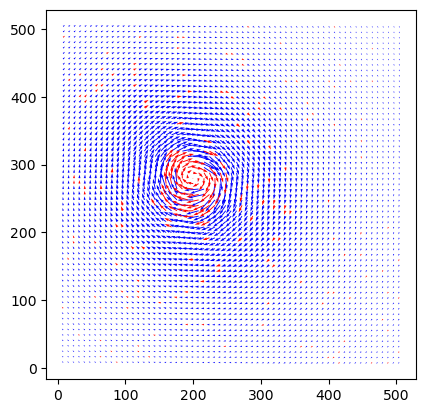

Image Pair 1
B005_1 B005_2
Saving to results/OpenPIV_results_16_test/field_A0001.txt


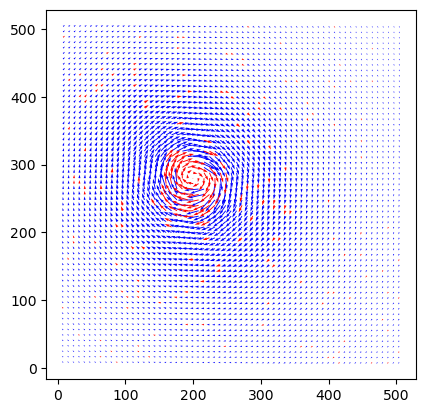

Image Pair 2
B005_3 B005_4


In [21]:
# Import necessary modules
from openpiv import windef
import pathlib

image_path = pathlib.Path(r'./images/')

file_list = []
for path in sorted(image_path.rglob('*.tif')):
    print(f'{path.name}')
    file_list.append(path.name)

# Create settings object
settings = windef.PIVSettings()

# Data related settings
settings.filepath_images = image_path #'./images/' # Folder with the images to process
settings.save_path = './results/' # Folder for the outputs
# Root name of the output Folder (if any) for Result Files
settings.save_folder_suffix = 'test'
# Format and Image Sequence (see below for more options)
#settings.frame_pattern_a = 'exp1_001_b.bmp'
#settings.frame_pattern_b = 'exp1_001_c.bmp'
# or if you have a sequence:
settings.frame_pattern_a = '*.tif'
# settings.frame_pattern_b = '(1+2),(2+3)'
# settings.frame_pattern_b = '(1+3),(2+4)'
settings.frame_pattern_b = '(1+2),(3+4)'

# Format and Image Sequence
#settings.frame_pattern_a = '*.bmp' # file_list[0]

# settings.frame_pattern_b = file_list[1]
#settings.frame_pattern_b = None

# If you want only one pair
#settings.frame_pattern_a = file_list[0]
#settings.frame_pattern_b = file_list[1]


# Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.roi = 'full'

# Configure settings for advanced analysis
settings.windowsizes = (64, 32, 16) # it should be a power of 2
settings.overlap = (32, 16, 8) # This is 50% overlap. In general window size/2 is a good choice.
settings.num_iterations = 3 # select the number of PIV passes
settings.correlation_method = 'circular' # 'circular' or 'linear'
settings.normalized_correlation = False
settings.subpixel_method = 'gaussian' # 'gaussian','centroid','parabolic'
settings.deformation_method = 'symmetric'
settings.interpolation_order = 3 # order of the image interpolation for the window deformation

# Signal to noise ratio options (only for the last pass)
# It is possible to decide if the S/N should be computed (for the last pass) or not
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_method = 'peak2peak' # 'peak2peak' or 'peak2mean'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2

# Set vector validation parameters
settings.validation_first_pass = True # choose if you want to do validation of the first pass
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.min_max_u_disp = (-30, 30)
settings.min_max_v_disp = (-30, 30)
# The second filter is based on the global STD threshold
settings.std_threshold = 7  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Options: True or False
settings.sig2noise_threshold = 1.2 # minmum signal to noise ratio that is need for a valid vector

# Outlier replacement or Smoothing options
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # True or False
settings.smoothn = True #Enables smoothing of the displacement field
settings.smoothn_p = 0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method

settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# Output options
# Select if you want to save the plotted vector field: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield

# Run PIV analysis with the given settings
windef.piv(settings)

## Conclusion

Advanced PIV techniques in OpenPIV provide powerful tools for improving accuracy and spatial resolution in PIV analysis. Window deformation and multi-pass processing address limitations of basic PIV analysis, while comprehensive validation methods ensure reliable vector fields. These techniques are particularly valuable for complex flows with high shear, rotation, or spatial gradients.